<h1><center>Laboratorio 6: El Pandas no Muerde (act III) 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudantes: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1:
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** `http://....`


## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Aplicar los paradigmas y buenas prácticas de programación vistas hasta este momento.
- Comprender y aprovechar las ventajas que nos ofrece la liberia `numpy` con respecto a trabajar en Python 'puro'.
- Visualizar aplicaciones de filtros de imágenes sin el uso de librerías.
- Verificar que el uso indiscriminado de `for` puede afectar en la eficiencia en al procesar datos masivos.


El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [4]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from scipy import stats

from IPython.display import display, Markdown, Latex

#Libreria para plotear
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

In [2]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin Mora quien es el gerente de una cotizada tienda de retail en Europa, les solicita si pueden analizar los datos de algunas de sus tiendas y si es posible extraer los diferenciar los tipos de clientes que posee el retail.

Para esto, el área de ventas les entrega el archivo `online_retail_II.xlsx` con el que se les pide que cargue y visualicen algunas de las filas que componen el Dataset.

Realice una primera visualización de los datos y señale los atributos que componen el dataset. Señale las columnas que conforman el dataset, el tipo de variable presente en cada columna y comente que representa cada una de estas.

**Respuesta:**

In [5]:
df_retail = pd.read_pickle("online_retail_II.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": str,
        "Customer ID": "category",
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


```
Las columnas del dataset son:
Invoice: category -> Código de boleta para la venta
StockCode: category -> Código del producto incluído en la boleta
Description: string -> Descripción del producto 
Quantity: int -> Cantidad del producto incluído en la venta
InvoiceDate: datetime: -> Fecha y hora de la emisión de la boleta
Price: float -> Precio por artículo
Customer ID: category -> Número identificador del cliente al que se le hace la boleta
Country: string -> País desde donde se realiza el pedido
```

## 1.2 Análisis Explotatorio de los Datos [0.5 puntos] 

En base a la primera visualización del dataset, *Don Mora* le solicita que realicen un análisis exploratorio de los datos, para esto les deberán realizar un análisis univariado y multivariado. De la revisión, ustedes deben explicar potenciales anomalías visualizadas y señalar si existe la necesidad de realizar una limpieza de datos.

Explique a que nos referimos con análisis univariable, multivariable y de datos faltantes. ¿Qué beneficios nos otorga estudiar estos datos?. Sea conciso con su respuesta y no escriba mas de 5 líneas para su respuesta.

**Respuesta a la Pregunta:**

El análisis univariable corresponde al análisis de una sola variable de los datos, el cual nos permite estudiar una única variable y ver todas sus características estadísticas para describirla completamente. Por otro lado, el análisi multivariable corresponde al análisis de dos o más variables de los datos para encontrar relaciones entre ellas. Así, esto nos permite interpretar de mejor manera los datos y sacar mejores conclusiones. Finalmente, el análisis de datos faltantes nos permite ver la distribución de los datos inexistentes, en caso de existir, y así tomar decisiones con respecto a la limpieza de los datos, o en casos más extremos, la utilidad de ellos.

### 1.2.1 Análisis Univariado [2 Puntos]

A continuación, se le presentan dos funciones para analizar los datos que componen un dataframe. La primera de estas es la función ``profile_serie()`` la cual recibe una serie y le entrega un análisis detallado de los datos que conforman dicha serie. 

Ejecute la funcion ``profile_serie()`` sobre cada serie para realizar un análisis univariado de estas. A continuación, comente acerca de el comportamiento de cada variable según las estadísticas descriptivas y los gráficos generados.

In [1]:
from pandas.api.types import is_numeric_dtype
from pandas.core.dtypes.common import is_datetime_or_timedelta_dtype


def profile_serie(serie_in, n_samples=1000, random_state=42):
    serie = serie_in.copy()

    profile = pd.Series(dtype='object')
    profile["Type"] = serie.dtype
    profile = pd.concat([profile, serie.describe(datetime_is_numeric=True)])

    # profile = pd.Series([])

    if is_numeric_dtype(serie):
        profile["Negative"] = (serie < 0).sum()
        profile["Negative (%)"] = (
            str(round((serie < 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Zeros"] = (serie == 0).sum()
        profile["Zeros (%)"] = (
            str(round((serie == 0).sum() / len(serie) * 100, 2)) + " %"
        )
        profile["Kurt"] = serie.kurt()
        profile["Skew"] = serie.skew()

    profile[" "] = " "  # espacio

    profile["Missing cells"] = serie.isnull().sum()
    profile["Missing cells (%)"] = (
        str(round(serie.isnull().sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Duplicate rows"] = serie.duplicated(False).sum()
    profile["Duplicate rows (%)"] = (
        str(round(serie.duplicated(False).sum() / len(serie) * 100, 2)) + " %"
    )
    profile["Total size in memory"] = str(serie.memory_usage(index=True)) + " bytes"

    # profile = pd.concat([profile, description])

    profile = profile.rename(
        index={
            "count": "Number of observations",
            "mean": "Mean",
            "std": "Std",
            "min": "Min",
            "max": "Max",
            "unique": "Unique",
            "top": "Top",
            "freq": "Freq",
        }
    )
    no_outliers_fig = None

    if is_numeric_dtype(serie):

        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(
            sampled_serie, marginal="box", title=f"{serie.name} - With Outliers"
        )

        no_outliers = sampled_serie.loc[(np.abs(stats.zscore(sampled_serie)) < 3)]
        # zscore = https://es.wikipedia.org/wiki/Unidad_tipificada
        
        no_outliers_fig = px.histogram(
            no_outliers, marginal="box", title=f"{serie.name} - Without Outliers"
        )

    elif is_datetime_or_timedelta_dtype(serie):
        sampled_serie = serie.sample(n_samples, random_state=random_state)
        fig = px.histogram(sampled_serie, marginal="box", title=f"{serie.name}")
    
    else:
            count = (
                serie.value_counts()[0:100]
                .reset_index()
                .rename(columns = {serie.name: 'Count'})
            )
            fig = px.bar(
                x=count['index'].astype(str),
                y=count["Count"],
                title=f"100 Most common categories of {serie.name}",
            )
    
    display(Markdown(f'## {serie.name} Profile'))
    display(profile)
    fig.show()

    if no_outliers_fig:
        no_outliers_fig.show()

    # return fig, profile

In [15]:
profile_serie(df_retail['Invoice']) 

## Invoice Profile

Type                           category
Number of observations           525461
Unique                            28816
Top                              537434
Freq                                675
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   517456
Duplicate rows (%)              98.48 %
Total size in memory      2338386 bytes
dtype: object

Podemos notar que en general, los clientes compran muchos artículos al mismo tiempo. 

In [16]:
profile_serie(df_retail['StockCode'])

## StockCode Profile

Type                           category
Number of observations           525461
Unique                             4632
Top                              85123A
Freq                               3516
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   525026
Duplicate rows (%)              99.92 %
Total size in memory      1220242 bytes
dtype: object

    Análisis de la n-esima serie...

In [17]:
profile_serie(df_retail['Description'])

## Description Profile

Type                                                  object
Number of observations                                525461
Unique                                                  4682
Top                       WHITE HANGING HEART T-LIGHT HOLDER
Freq                                                    3549
                                                            
Missing cells                                              0
Missing cells (%)                                      0.0 %
Duplicate rows                                        525198
Duplicate rows (%)                                   99.95 %
Total size in memory                           4203816 bytes
dtype: object

    Análisis de la n-esima serie...

In [18]:
profile_serie(df_retail['Quantity'])

## Quantity Profile

Type                              int64
Number of observations    525461.000000
Mean                          10.337667
Std                          107.424110
Min                        -9600.000000
25%                            1.000000
50%                            3.000000
75%                           10.000000
Max                        19152.000000
Negative                          12326
Negative (%)                     2.35 %
Zeros                                 0
Zeros (%)                         0.0 %
Kurt                        6277.666908
Skew                          36.044617
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   525122
Duplicate rows (%)              99.94 %
Total size in memory      4203816 bytes
dtype: object

    Análisis de la n-esima serie...

In [19]:
profile_serie(df_retail['InvoiceDate']) 

## InvoiceDate Profile

Type                                     datetime64[ns]
Number of observations                           525461
Mean                      2010-06-28 11:37:36.845017856
Min                                 2009-12-01 07:45:00
25%                                 2010-03-21 12:20:00
50%                                 2010-07-06 09:51:00
75%                                 2010-10-15 12:45:00
Max                                 2010-12-09 20:01:00
                                                       
Missing cells                                         0
Missing cells (%)                                 0.0 %
Duplicate rows                                   520400
Duplicate rows (%)                              99.04 %
Total size in memory                      4203816 bytes
dtype: object

    Análisis de la primera serie...

In [20]:
profile_serie(df_retail['Price'])

## Price Profile

Type                            float64
Number of observations    525461.000000
Mean                           4.688834
Std                          146.126914
Min                       -53594.360000
25%                            1.250000
50%                            2.100000
75%                            4.210000
Max                        25111.090000
Negative                              3
Negative (%)                      0.0 %
Zeros                              3687
Zeros (%)                         0.7 %
Kurt                       64868.344873
Skew                        -140.768446
                                       
Missing cells                         0
Missing cells (%)                 0.0 %
Duplicate rows                   524485
Duplicate rows (%)              99.81 %
Total size in memory      4203816 bytes
dtype: object

    Análisis de la n-esima serie...

In [21]:
profile_serie(df_retail['Customer ID'])

## Customer ID Profile

Type                           category
Number of observations         417534.0
Unique                           4383.0
Top                             14911.0
Freq                             5710.0
                                       
Missing cells                    107927
Missing cells (%)               20.54 %
Duplicate rows                   525327
Duplicate rows (%)              99.97 %
Total size in memory      1218250 bytes
dtype: object

    Análisis de la n-esima serie...

In [22]:
profile_serie(df_retail['Country'])

## Country Profile

Type                              object
Number of observations            525461
Unique                                40
Top                       United Kingdom
Freq                              485852
                                        
Missing cells                          0
Missing cells (%)                  0.0 %
Duplicate rows                    525461
Duplicate rows (%)               100.0 %
Total size in memory       4203816 bytes
dtype: object

    Análisis de la n-esima serie...

### 1.2.2 Análisis Multivariado y Datos Faltantes [1 ptos]

En segundo lugar encontrará la función ``profile_df()`` que recibe un dataframe como entrada y realiza un análisis bivariado de todas las variables numéricas que conforman el dataframe, un analisis de la correlación de Pearson entre las variables numericas del dataframe y la matriz de datos faltantes. Ejecute la función `profile_df` y comente sus resultados.

In [14]:
def profile_df(dataframe_in):
    df = dataframe_in.copy()

    list_type = []
    for col in list(df.columns):
        if is_numeric_dtype(df[col]) or \
        pd.core.dtypes.common.is_datetime_or_timedelta_dtype(df[col]):
            list_type.append(col)
            
    print("Numeric columns:")
    for col in list_type:
        print(col)
    display(Markdown('## Bivariant Analysis:'))
    for i in range(len(list_type)):
        for j in range(i+1, len(list_type)):
            plt.scatter(df[list_type[i]], df[list_type[j]])
            plt.xlabel(list_type[i]) 
            plt.ylabel(list_type[j]) 
            plt.title(f"{list_type[i]} v/s {list_type[j]}")
            plt.show()

    display(Markdown('## Correlation:'))
    fig_corr = px.imshow(df[list_type].corr())
    fig_corr.show()

    display(Markdown('## Missing Matrix:'))
    fig, ax = plt.subplots(figsize=[15, 10])
    msno.matrix(df, ax=ax, sparkline=False)

Numeric columns:
Quantity
InvoiceDate
Price


## Bivariant Analysis:

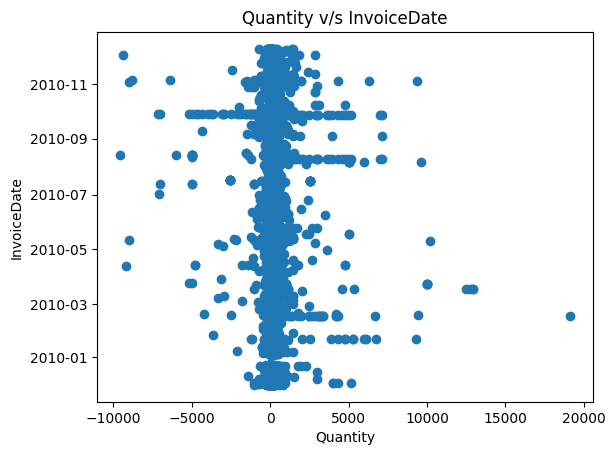

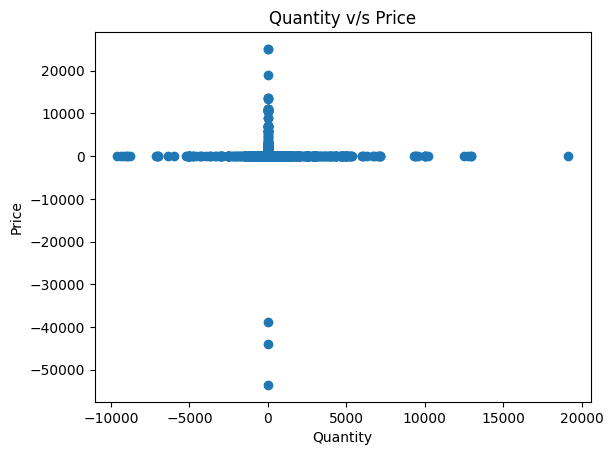

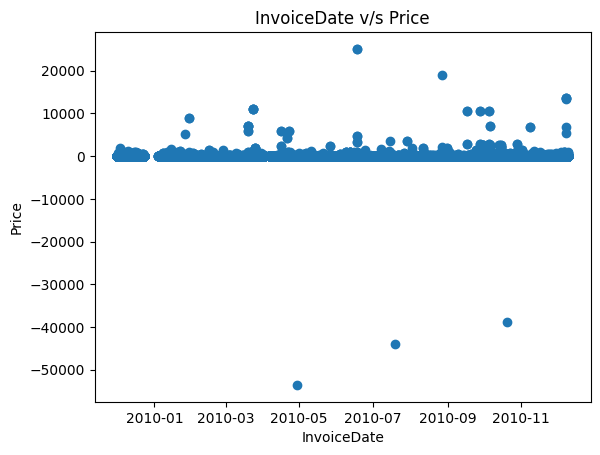

## Correlation:

## Missing Matrix:

c:\Users\Nico\Desktop\uchile\MDS7202 - Laboratorio de Programación Científica para Ciencia de Datos\lab6\lib\site-packages\missingno\missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



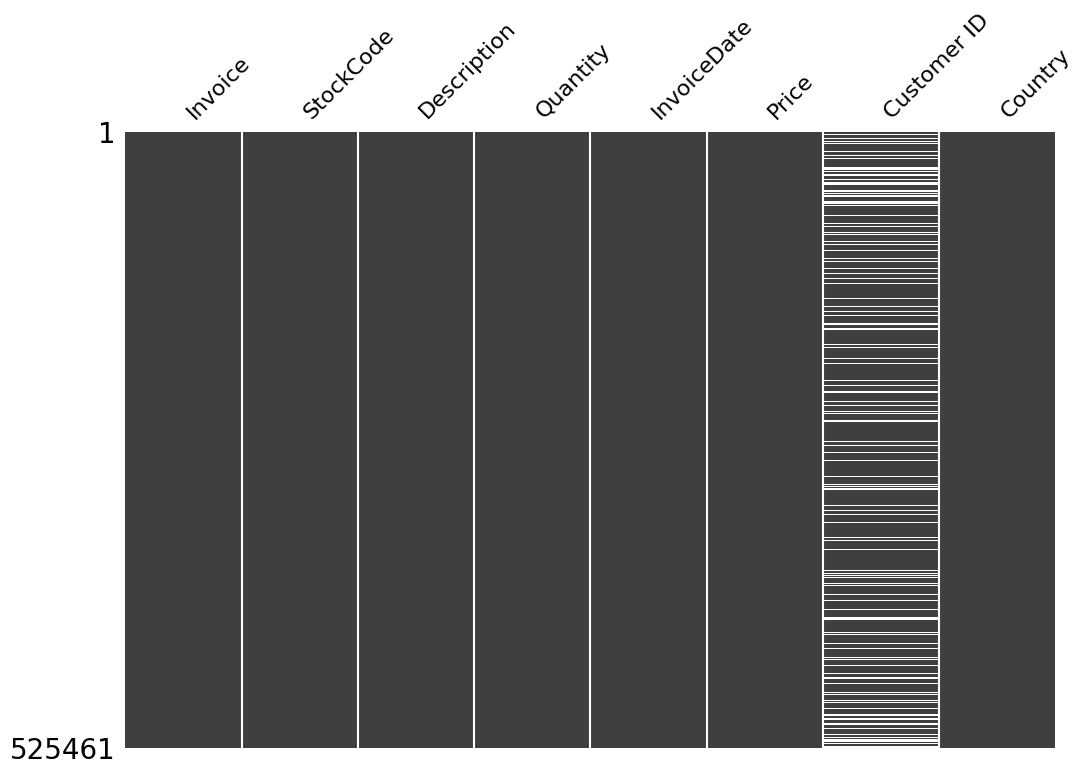

In [13]:
profile_df(df_retail)

### 1.2.3 Limpieza de Datos [1 pto]

Como pudo ver en las secciones anteriores, los datos presentan valores erroneos, es por esto que se le solicita que genere una función que permita limpiar el dataset. Realice esta función en base observaciones propias y considere como imposible tener cantidades negativas en las ventas.

Una vez realizada la función, realice nuevamente el análisis exploratorio y comente las principales diferencias.

**Respuesta:**

In [ ]:
Código Aquí

### 1.2.4 Obtención de TOPs [0.75 ptos]

Sin considerar los comentarios realizados en la sección 1.2 , *Don Mora* les pide obtener el **Top de 30 productos que generan más ganancias** para la tienda de retail. Deben considerar todo el registro temporal presente en el dataset y entregar la información en un gráfico de barras de los ingresos/cantidades v/s el nombre de los productos (Utilice `plotly`). ¿Los artículos más vendidos son los mismos que generan más ganancias?, Comente los resultados obtenidos.

**Resultados:**

In [ ]:
> Código Aquí

### 1.2.5 Visualización del registro temporal [0,75 ptos]

El dueño del retail en su afán por saber más sobre los datos de su firma les solicita que grafiquen las ventas respecto al tiempo. Con esto les aclara que durante el día tienen muchas variaciones en sus ventas, por lo que les recomienda que consideren el registro temporal como `año-mes-día`. ¿Es posible observar datos extraños?, Comente lo que observa del gráfico.

In [7]:
def plot_ventas(dataframe):
    pass

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>